In [17]:
import os
import math
import sys
import shutil
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

import tensorflow as tf
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Attention, BatchNormalization, ReLU, LSTM, Dropout, Conv1DTranspose, Flatten, TimeDistributed, Concatenate, Layer
from keras.models import Model, Sequential
import keras
from keras import layers
from sklearn.utils import class_weight
import ipywidgets as widgets



In [18]:
# Input disease name
disease_box = widgets.Text(
    value='respiratory_HiRID',
    placeholder='respiratory_HiRID, circulatory, kidney or sepsis',
    description='Disease:',
    disabled=False,
    layout=widgets.Layout(width='500px')
)

# Display the text box
display(disease_box)

# Input hours before & after onset to label as positive
label_freq = widgets.Label('Enter the sampling frequency of the input (minutes):')

sampling_freq_box = widgets.Text(
    value='30',
    placeholder='30',
    description='Minutes:',
    disabled=False,
    layout=widgets.Layout(width='500px')
)

# Display the text box
display(label_freq, sampling_freq_box)

Text(value='respiratory_HiRID', description='Disease:', layout=Layout(width='500px'), placeholder='respiratory…

Label(value='Enter the sampling frequency of the input (minutes):')

Text(value='30', description='Minutes:', layout=Layout(width='500px'), placeholder='30')

In [19]:
main_folder_path = '/datasets/amelatur/mimic_m1pz92hj/' # path with patient IDs
ids_file = pd.read_csv( main_folder_path + '0labels.txt')
patient_ids = ids_file['id']
vitals_folder_path = '/datasets/amelatur/mimic_kih7jlb3/' # path with patient vitals

disease = str(disease_box.value)
onset_file_path = '/datasets/amelatur/data_slices/onset_files/' + disease + '_onset_index.csv' # path with onset indices
onset_indices_csv = pd.read_csv(onset_file_path, header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

save_file_path = '/datasets/amelatur/whole_sequences_AE/' + disease +'/'

# delete save_file_path if it already exists
if os.path.exists(save_file_path):
    shutil.rmtree(save_file_path)

# create empty save_file_path
if not os.path.exists(save_file_path):
    os.makedirs(save_file_path)

sampling_freq_minutes = int(sampling_freq_box.value)
max_seq_length = (60 // sampling_freq_minutes) * 24 * 7 # max seq length is 7 days
min_seq_length = (60 // sampling_freq_minutes) * 12 # min seq length is 12 hours


In [20]:
# train test split
train_size = 0.8
train_patients = patient_ids.sample(frac=train_size, random_state=0)
test_patients = patient_ids.drop(train_patients.index)
print('Test patients:', len(test_patients))


# validation
validation_size = 0.15
validation_patients = train_patients.sample(frac=validation_size, random_state=0)
train_patients = train_patients.drop(validation_patients.index)
print('Validation patients:', len(validation_patients))
print('Train patients:', len(train_patients))


Test patients: 14548
Validation patients: 8729
Train patients: 49464


In [143]:
def get_data(patient_id):

    exclusion_flag = 0

    # get labs to apply exclusion criteria
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])
    labs_file = labs_file.sort_values(by='charttime').set_index('charttime')

    n_steps = len(labs_file.index)

    # P/F ratio
    if (labs_file['po2'].isna().all() or n_steps < min_seq_length or n_steps > max_seq_length):
        exclusion_flag = 1

    # get onset time
    onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == patient_id]['Onset_Index'].values[0])
    
    # load vitals
    vitals_file = pd.read_csv(vitals_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    vitals_file = vitals_file.set_index('time').drop(['Unnamed: 0', 'id'], axis=1)

    # Assume `df` is your DataFrame and `ranges` is a dictionary with column names as keys and ranges as values
    # df = pd.DataFrame(...)  # replace this with your DataFrame
    # ranges = {'column1': (lower1, upper1), 'column2': (lower2, upper2), ...}  # replace this with your ranges

    ranges = {'heartrate':(0.0, 300.0), 'sbp': (10.0, 300.0), 'dbp': (10.0, 175.0), 'mbp': (10.0, 200.0), 'respiration': (0.0, 45.0), 'temperature': (25.0, 45.0), 'spo2': (10.0, 100.0)}

    # Replace values with NaNs if they are outside the specified range for each column
    vitals_file = vitals_file.apply(lambda col: np.where((col < ranges[col.name][0]) | (col > ranges[col.name][1]), np.nan, col))
    vitals = vitals_file.resample('30T').mean() 
    vitals = vitals.interpolate().ffill().bfill()
    if vitals.isna().any().any():
        exclusion_flag = 1
    vitals = vitals.to_numpy()


    last_index = len(vitals)

    return patient_id, vitals, exclusion_flag, onset_index, last_index
        

In [144]:
def save_data(patient_id, vitals):

    # save data
    np.save(save_file_path + str(patient_id) + '_vitals.npy', np.array(vitals))

    # print('Patient:', patient_id, 'saved')

    return 0

In [145]:
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_mean_and_var(pat_id):
    patient_id, vitals, exclusion_flag, onset_index, last_index = get_data(pat_id)
    
    if exclusion_flag == 0:
        mean = np.mean(vitals, axis=0)
        var = np.var(vitals, axis=0)

        # also compute class weights
        return mean, var
    else:
        return None, None

results = Parallel(n_jobs=-1)(delayed(compute_mean_and_var)(pat_id) for pat_id in tqdm(train_patients))

# Filter out None results
results = [result for result in results if result[0] is not None]

means, vars = zip(*results)

overall_mean = np.mean(np.array(means), axis=0)
overall_std = np.sqrt(np.mean(np.array(vars), axis=0))   




















/tmp/ipykernel_2791570/2003030297.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_2791570/2003030297.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.






























/tmp/ipykernel_2791570/2003030297.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.






/tmp/ipykernel_2791570/2003030297.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_2791570/2003030297.py:21: UserWa

In [146]:
overall_mean, overall_std

(array([ 85.91640428, 118.25272341,  62.6288257 ,  78.01817065,
         19.39711267,  36.83743607,  96.56372174]),
 array([10.13870251, 13.82908423,  9.71550225, 10.27792566,  3.87094506,
         0.41334294,  2.74597765]))

In [147]:
def iterate_patients_save(pat_id):
    patient_id, vitals, exclusion_flag, onset_index, last_index = get_data(pat_id) # get inputs and targets

    if exclusion_flag == 0:

        # normalize the inputs/vitals
        vitals = (vitals - overall_mean) / overall_std
        
        vitals = tf.keras.preprocessing.sequence.pad_sequences([vitals],maxlen=max_seq_length, padding='post', truncating='post', value=100000, dtype='float32')

        # remove the first dimension of the inputs and targets
        vitals = np.squeeze(vitals, axis=0)

        save_data(patient_id, vitals)

        return vitals
    else:
        return None


res = Parallel(n_jobs=-1)(delayed(iterate_patients_save)(pat_id) for pat_id in tqdm(train_patients))

  0%|          | 0/49464 [00:00<?, ?it/s]2024-03-28 19:05:52.180003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 19:05:52.180399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 19:05:52.181320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 19:05:52.181373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 19:05:52.181769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLA

In [148]:
res = Parallel(n_jobs=-1)(delayed(iterate_patients_save)(pat_id) for pat_id in tqdm(validation_patients))
res = Parallel(n_jobs=-1)(delayed(iterate_patients_save)(pat_id) for pat_id in tqdm(test_patients))

 30%|███       | 4416/14548 [00:08<00:20, 503.20it/s]/tmp/ipykernel_2791570/2003030297.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_2791570/2003030297.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 74%|███████▍  | 10752/14548 [00:20<00:07, 514.99it/s]/tmp/ipykernel_2791570/2003030297.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_2791570/2003030297.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a for

In [125]:

def data_generator(patient_ids_selected):

    for pat_id in patient_ids_selected:
        
        vital_path = save_file_path + str(pat_id) + '_vitals.npy'
        onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == pat_id]['Onset_Index'].values[0])

        if os.path.exists(vital_path) and np.isnan(onset_index) == True: # load only negative patients
            try:
                vitals = np.load(vital_path)

                row_index = np.where(np.all(vitals == 100000.0, axis=1))[0][0] 

                decoder_input = np.zeros((vitals.shape[0], 1))
                decoder_input[row_index:, :] = 100000.0

                yield (vitals, decoder_input), vitals
            except:
                pass
            
def custom_data_loader(batch_size, patient_ids_selected):

    # Shuffle the patient ids
    shuffled_series_patients = patient_ids_selected.sample(frac=1)

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(shuffled_series_patients), 
        output_signature=(
                (tf.TensorSpec(shape=(336, 7), dtype=tf.float32), tf.TensorSpec(shape=(336, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(336, 7), dtype=tf.float32),
        )
    )

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

batch_size = 32

data_loader = custom_data_loader(batch_size, train_patients)

val_data_loader = custom_data_loader(batch_size, validation_patients)

#for batch in data_loader:
for (inputs, decoder_inputs), targets in val_data_loader:

    print("Inputs shape:", inputs.shape)
    print("Decoder inputs shape:", decoder_inputs.shape)
    print("Targets shape:", targets.shape)
    break

Exception ignored in: <generator object data_generator at 0x7fbe7cc04eb0>
Traceback (most recent call last):
  File "/home/amelatur/.pyenv/versions/3.10.12/envs/my_proj/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 870, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
RuntimeError: generator ignored GeneratorExit


Inputs shape: (32, 336, 7)
Decoder inputs shape: (32, 336, 1)
Targets shape: (32, 336, 7)


In [126]:
pat_id = train_patients.sample(1).values[0]

vital_path = save_file_path + str(pat_id) + '_vitals.npy'
vitals = np.load(vital_path)

row_index = np.where(np.all(vitals == 100000.0, axis=1))[0][0]
row_index


103

In [127]:
from tensorflow.keras.layers import LSTM, Layer
import tensorflow as tf


def create_lstm_encoder_decoder(input_shape, target_shape):
    # Define an input sequence and process it.
    latent_dim = 256
    num_decoder_tokens = target_shape[0]

    # Define an input sequence and process it.
    enc_inputs = Input(shape=input_shape)
    encoder_inputs = keras.layers.Masking(mask_value=100000.0)(enc_inputs)

    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    dec_inputs = Input(shape=target_shape)

    decoder_inputs = keras.layers.Masking(mask_value=100000.0)(dec_inputs)
    decoder_lstm = LSTM(128, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Add a TimeDistributed Dense layer to make a prediction for each timestep
    decoder_dense = TimeDistributed(Dense(7, activation=None))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([enc_inputs, dec_inputs], decoder_outputs)

    return model

In [128]:
loss_object = loss=tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=None, epsilon=1e-8)


input_shape = (None, 7)
target_shape = (None, 1)
model = create_lstm_encoder_decoder(input_shape,  target_shape)

model.compile(loss=loss_object, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()



Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, None, 7)]            0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, None, 1)]            0         []                            
                                                                                                  
 masking_20 (Masking)        (None, None, 7)              0         ['input_25[0][0]']            
                                                                                                  
 masking_21 (Masking)        (None, None, 1)              0         ['input_26[0][0]']            
                                                                                            

In [129]:

model.fit(data_loader, epochs=150, validation_data=val_data_loader)  

Epoch 1/150


    252/Unknown - 21s 66ms/step - loss: 1.6730 - root_mean_squared_error: 1.2943

2024-03-28 17:44:15.669106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4019083460076804242
2024-03-28 17:44:15.669131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 583780395669572744
2024-03-28 17:44:15.669136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14057632453104012530
2024-03-28 17:44:15.669165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15694380138945200333
2024-03-28 17:44:15.669181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 221991678044379453
2024-03-28 17:44:15.669186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4368501083435203891
2024-03-28 17:44:15.669193: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

252/252 [==============================] - 25s 82ms/step - loss: 1.6730 - root_mean_squared_error: 1.2943 - val_loss: 1.5832 - val_root_mean_squared_error: 1.2612
Epoch 2/150
  2/252 [..............................] - ETA: 12s - loss: 1.5208 - root_mean_squared_error: 1.2334

2024-03-28 17:44:19.754770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12036551740750081409
2024-03-28 17:44:19.754796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2578674798850691956
2024-03-28 17:44:19.754801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17591471059236207504
2024-03-28 17:44:19.754807: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17130779565760685788


252/252 [==============================] - 20s 77ms/step - loss: 1.6702 - root_mean_squared_error: 1.2935 - val_loss: 1.5872 - val_root_mean_squared_error: 1.2627
Epoch 3/150
252/252 [==============================] - 20s 78ms/step - loss: 1.5945 - root_mean_squared_error: 1.2636 - val_loss: 1.5219 - val_root_mean_squared_error: 1.2369
Epoch 4/150
252/252 [==============================] - 20s 78ms/step - loss: 1.4119 - root_mean_squared_error: 1.1889 - val_loss: 1.2295 - val_root_mean_squared_error: 1.1117
Epoch 5/150
252/252 [==============================] - 19s 77ms/step - loss: 1.1178 - root_mean_squared_error: 1.0578 - val_loss: 1.0385 - val_root_mean_squared_error: 1.0215
Epoch 6/150
252/252 [==============================] - 19s 77ms/step - loss: 1.0109 - root_mean_squared_error: 1.0061 - val_loss: 0.9714 - val_root_mean_squared_error: 0.9875
Epoch 7/150
252/252 [==============================] - 19s 77ms/step - loss: 0.9498 - root_mean_squared_error: 0.9753 - val_loss: 0.9354 

### EVALUATION

In [130]:

def data_generator_neg(patient_ids_selected):

    for pat_id in patient_ids_selected:
        
        vital_path = save_file_path + str(pat_id) + '_vitals.npy'
        onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == pat_id]['Onset_Index'].values[0])

        if os.path.exists(vital_path) and np.isnan(onset_index) == True: # load only negative patients
            try:
                vitals = np.load(vital_path)

                row_index = np.where(np.all(vitals == 100000.0, axis=1))[0][0] 

                decoder_input = np.zeros((vitals.shape[0], 1))
                decoder_input[row_index:, :] = 100000.0

                yield (vitals, decoder_input), vitals
            except:
                pass
            
def custom_data_loader_neg(batch_size, patient_ids_selected):

    # Shuffle the patient ids
    shuffled_series_patients = patient_ids_selected.sample(frac=1)

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_neg(shuffled_series_patients), 
        output_signature=(
                (tf.TensorSpec(shape=(336, 7), dtype=tf.float32), tf.TensorSpec(shape=(336, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(336, 7), dtype=tf.float32),
        )
    )

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


def data_generator_pos(patient_ids_selected):

    for pat_id in patient_ids_selected:
        
        vital_path = save_file_path + str(pat_id) + '_vitals.npy'
        onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == pat_id]['Onset_Index'].values[0])

        if os.path.exists(vital_path) and np.isnan(onset_index) == False: # load only positive patients
            try:
                vitals = np.load(vital_path)

                row_index = np.where(np.all(vitals == 100000.0, axis=1))[0][0] 

                decoder_input = np.zeros((vitals.shape[0], 1))
                decoder_input[row_index:, :] = 100000.0

                yield (vitals, decoder_input), vitals
            except:
                pass
            
def custom_data_loader_pos(batch_size, patient_ids_selected):

    # Shuffle the patient ids
    shuffled_series_patients = patient_ids_selected.sample(frac=1)

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_pos(shuffled_series_patients), 
        output_signature=(
                (tf.TensorSpec(shape=(336, 7), dtype=tf.float32), tf.TensorSpec(shape=(336, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(336, 7), dtype=tf.float32),
        )
    )

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

batch_size = 32

data_loader_neg_test = custom_data_loader_neg(batch_size, test_patients)
data_loader_pos_test = custom_data_loader_pos(batch_size, test_patients)

In [131]:
model.evaluate(data_loader_neg_test)

77/77 [==============================] - 5s 64ms/step - loss: 0.3717 - root_mean_squared_error: 0.6109


2024-03-28 18:33:29.273986: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10904417942017762883
2024-03-28 18:33:29.274003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10851323644175579987
2024-03-28 18:33:29.274008: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 722506077141146721
2024-03-28 18:33:29.274011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11381115916212432339
2024-03-28 18:33:29.274014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12036551740750081409
2024-03-28 18:33:29.274018: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16954827671461001079
2024-03-28 18:33:29.274023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

[0.3717060089111328, 0.6109426617622375]

In [132]:
model.evaluate(data_loader_pos_test)

142/142 [==============================] - 6s 41ms/step - loss: 0.4738 - root_mean_squared_error: 0.6902


2024-03-28 18:33:38.927135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10904417942017762883
2024-03-28 18:33:38.927152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 722506077141146721
2024-03-28 18:33:38.927157: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11381115916212432339
2024-03-28 18:33:38.927160: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12036551740750081409
2024-03-28 18:33:38.927164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16954827671461001079
2024-03-28 18:33:38.927168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2578674798850691956
2024-03-28 18:33:38.927171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

[0.47376954555511475, 0.6901679039001465]

39606067
1/1 [==============================] - 0s 14ms/step
nan


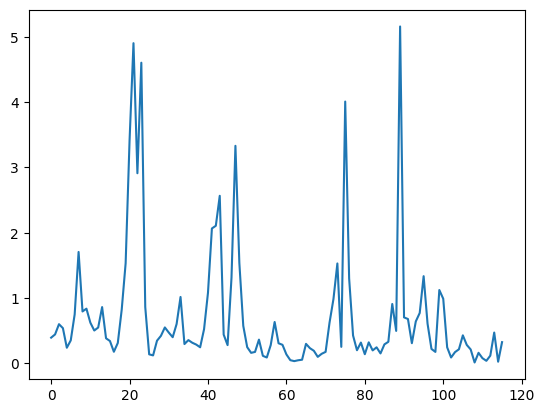

nan


In [155]:
#pat_id = test_patients.sample(1).values[0]
pat_id = 39606067

patient_id, vitals, exclusion_flag, onset_index, last_index = get_data(pat_id)

if exclusion_flag == 0:

    print(patient_id)

    vitals_pt = (vitals - overall_mean) / overall_std
    decoder_input = np.zeros((vitals.shape[0], 1))

    decoder_input = np.expand_dims(decoder_input, axis=0)
    vitals_pt = np.expand_dims(vitals_pt, axis=0)
    prediction = model.predict([vitals_pt, decoder_input])[0]                            
    onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == pat_id]['Onset_Index'].values[0])
    print(onset_index)

    mse = np.mean(np.square(prediction - vitals_pt), axis=2)

    # plot time series
    import matplotlib.pyplot as plt
    plt.plot(mse.T[:last_index])
    #plt.plot(np.squeeze(vitals_pt))
    #plt.ylim([0, 0.001])
    plt.show()
    print(onset_index)

In [90]:
pat_id

36024074

In [74]:
input_sequences_test[0]

array([[-0.3684432 , -0.7315758 , -1.0154845 , ...,  0.08802015,
        -2.5917594 ,  1.0637951 ],
       [-0.3684432 , -0.7315758 , -1.0154845 , ...,  0.08802015,
        -2.5917594 ,  1.0637951 ],
       [-0.3684432 , -0.7315758 , -1.0154845 , ...,  0.08802015,
        -2.5917594 ,  1.0637951 ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)

In [16]:
respi_status.shape

(304, 7)

In [53]:
def eval(pat_id, idx):
    try:
        prediction = preds_test[idx]
        onset_index = (onset_indices_csv[onset_indices_csv['Patient_ID'] == pat_id]['Onset_Index'].values[0])
        target_seq = target_sequences_test[idx]
        
        first_minus_one_index = np.where(target_seq == -1)[0][0]
        prediction = prediction[:first_minus_one_index]

        prediction = mark_sequences((prediction > 0.5).astype(int), 4)
        #prediction = (prediction > 0.5).astype(int)

        if np.isnan(onset_index) == False: # ground truth is positive

            ground_truth = 1

            onset_index = int(onset_index)
            #prediction = (prediction[:onset_index] > 0.5).astype(int)

            prediction = prediction[:onset_index]
            final_pred = (np.sum(prediction) > 0).astype(int)
            
        else: # ground truth is negative
            ground_truth = 0
            final_pred = (np.sum(prediction) > 0).astype(int)

        return ground_truth, final_pred
    
    except:
        return None, None



In [54]:
ground_truths = []
final_preds = []

for pat_id, idx in zip(pat_ids_included, range(len(pat_ids_included))):
    ground_truth, final_pred = eval(pat_id, idx)
    if ground_truth is not None and final_pred is not None:
        ground_truths.append(ground_truth)
        final_preds.append(final_pred)



In [55]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(ground_truths, final_preds)

array([[170, 640],
       [725, 898]])

In [56]:
print(classification_report(ground_truths, final_preds))

              precision    recall  f1-score   support

           0       0.19      0.21      0.20       810
           1       0.58      0.55      0.57      1623

    accuracy                           0.44      2433
   macro avg       0.39      0.38      0.38      2433
weighted avg       0.45      0.44      0.45      2433

